In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [25]:
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/survey/mouse_kidney_13.h5ad')
adata

AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    obsm: 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

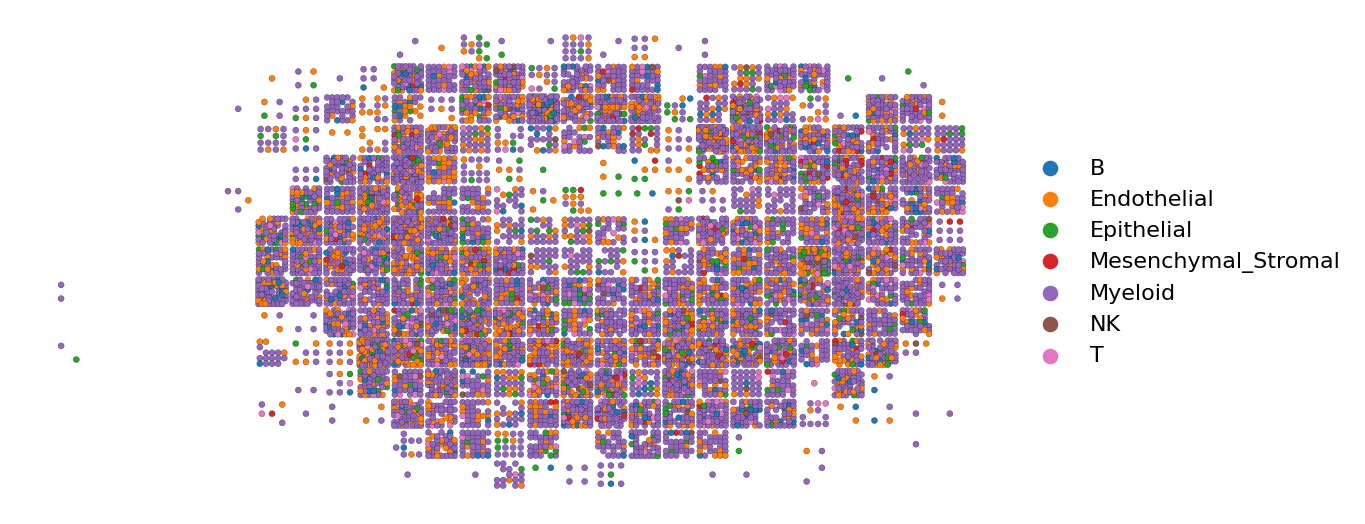

In [26]:
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams['figure.dpi'] = 160
sc.pl.embedding(adata, basis='spatial', color='cell_type', 
    frameon=False, edgecolor='black', s=30, linewidth=0.1, title='')


In [27]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')

In [28]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

In [29]:
adata.X = adata.layers['normalized_count'].copy()

In [30]:
# %%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca')
sc.tl.umap(adata)

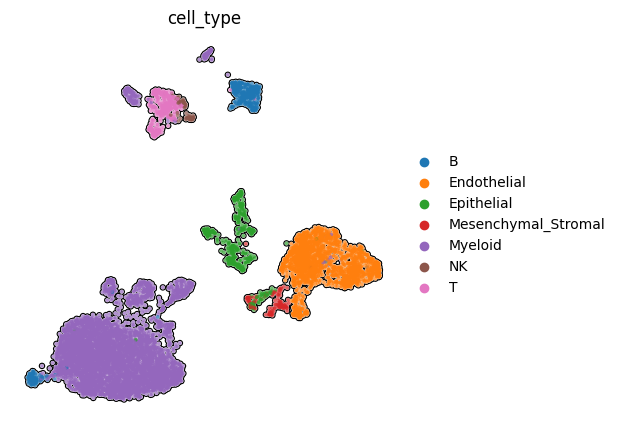

In [31]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 100

sc.pl.umap(adata, color='cell_type', frameon=False, s=30, add_outline=True)

In [32]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [33]:
base_GRN = co.data.load_mouse_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [34]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=10,
    verbose_level=2
)

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for B...


  0%|          | 0/2989 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:36<09:41, 96.98s/it]

Inferring GRN for Endothelial...


  0%|          | 0/2989 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [03:16<08:13, 98.69s/it]

Inferring GRN for Epithelial...


  0%|          | 0/2989 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [04:55<06:33, 98.50s/it]

Inferring GRN for Mesenchymal_Stromal...


  0%|          | 0/2989 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [06:29<04:50, 96.70s/it]

Inferring GRN for Myeloid...


  0%|          | 0/2989 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [09:04<03:55, 117.93s/it]

Inferring GRN for NK...


  0%|          | 0/2989 [00:00<?, ?it/s]

 86%|████████▌ | 6/7 [10:41<01:50, 110.75s/it]

Inferring GRN for T...


  0%|          | 0/2989 [00:00<?, ?it/s]

100%|██████████| 7/7 [12:16<00:00, 105.23s/it]

CPU times: user 8min 47s, sys: 19.4 s, total: 9min 6s
Wall time: 12min 16s


In [35]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=10, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [36]:
import pickle

with open('/Users/koush/Desktop/training_data/mouse_kidney_13_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [37]:
# adata.write_h5ad('/Users/koush/Desktop/training_data/mouse_kidney_13.h5ad')